In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.stats import mstats as ms
import scipy.stats as st
from datetime import datetime as dt

allstock = pd.read_csv('all_stocks_5yr.csv')
names = list(set(allstock.Name))
names.sort()

#allstock['Name'].value_counts()   #many stocks occur every day (1258 times), but many don't

The dataframe contains data of all S&P500 stocks.

In [3]:
allstock.head(4)

,Date,Open,High,Low,Close,Volume,Name
0,2012-08-13,92.29,92.59,91.74,92.40,2075391.0,MMM
1,2012-08-14,92.36,92.50,92.01,92.30,1843476.0,MMM
2,2012-08-15,92.00,92.74,91.94,92.54,1983395.0,MMM
3,2012-08-16,92.75,93.87,92.21,93.74,3395145.0,MMM


Analysis of some random stock
====

We start by selection a stock, and analyzing its (stochastic) behavior.

MAC
2012-08-13  --  2017-08-11


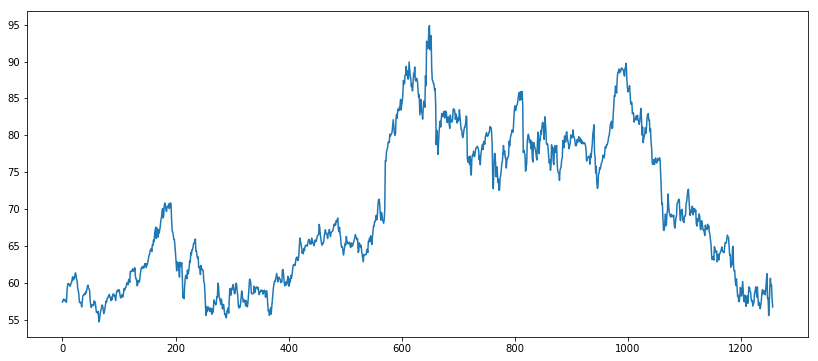

In [131]:
stock_name = np.random.choice(names)
print(stock_name)
stock = allstock[allstock['Name'] == stock_name].copy();
stock.sort_values('Date');
print(stock.Date.iloc[0], ' -- ',stock.Date.iloc[-1])
stock.dropna(axis =0, how = 'any', inplace = True)
stock['Date'] = stock['Date'].apply(lambda str: dt.strptime(str, '%Y-%m-%d'))
plt.figure(figsize = (14,6))
plt.plot(stock.Close.tolist())
plt.show()

del stock['Name']
del stock['Volume']

We have dropped any NaN-rows, and replaced the time by a datetime-object. Next, we'll look at the distribution of relative change of consecutive closing values.

In [132]:
stock['diff_close'] = stock['Close'].diff().copy()
stock['delta_t'] = stock['Date'].diff().copy()
stock.Close = stock.Close.shift(1)   # shift Close for later
stock = stock.iloc[1:, :].copy()
stock['delta_t'] = stock['delta_t'].apply(lambda d: d.days)
#stock_clean = stock.dropna(axis = 0, how = 'any')
#stock.diff_close = stock.diff_close.shift(-1)
#stock.delta_t = stock.delta_t.shift(-1)
#stock.dropna(axis =0, how = 'any', inplace = True)
#stock['delta_t'] = stock['delta_t'].apply(lambda d: d.days)
#stock['dc_dt'] = stock.diff_close / stock.delta_t

We ignore differences over longer time intervals than one day:

In [133]:
stock = stock[stock['delta_t'] == 1].copy()
dS_S = (stock.diff_close / stock.Close).tolist()

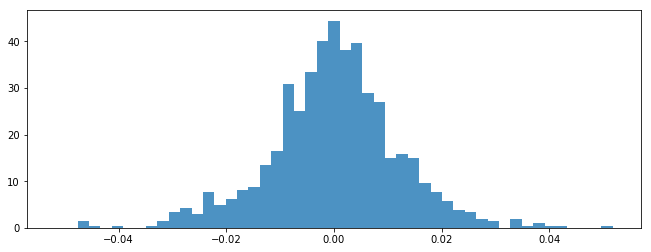

mean:  -0.028408809616
std:   0.247566181957
median:  0.113600995954


In [134]:
plt.figure(figsize = (11,4))
plt.hist(dS_S, bins=np.linspace(-4*np.std(dS_S), 4*np.std(dS_S), 50), alpha = 0.8, normed = True);
plt.show()

print("mean: " , np.mean(dS_S)*365)
print("std:  ", np.std(dS_S)*np.sqrt(365))
print("median: ", np.median(dS_S)*365)

We investigate normality, and compare it to a normal distribution:

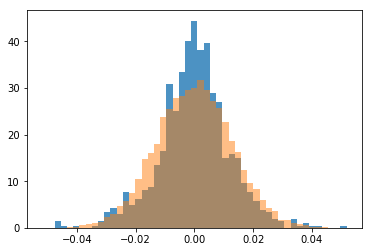

NormaltestResult(statistic=118.89437838519795, pvalue=1.5219969039609734e-26)
Ks_2sampResult(statistic=0.059860020345879977, pvalue=0.00310698578915176)


In [135]:
compare = np.random.normal(np.mean(dS_S), np.std(dS_S), 10000)   #comparison-sample; normally distributed
plt.hist(dS_S, bins=np.linspace(-4*np.std(dS_S), 4*np.std(dS_S), 50), alpha = 0.8, normed = True);
plt.hist(compare, bins=np.linspace(-4*np.std(dS_S), 4*np.std(dS_S), 50), alpha = 0.5, normed = True)
plt.show()
print(ms.normaltest(dS_S))
print(st.ks_2samp(dS_S, compare))

**Interpretation**: In the normality test, normality is *rejected* if $p\approx 0$. In the Kolmogorov-test, the hypothesis that the distributions are the same is rejected if $p\approx 0$.
The results are very clear in this case: the daily rate of change (between adjacent closing prices) is not normally distributed. I attribute this mainly to apparent heavy tails. This becomes clear if we cut off the tails:

In [136]:
dS_S_cutoff = (stock.diff_close / stock.Close)
dS_S_cutoff = dS_S_cutoff[(dS_S_cutoff > -2*np.std(dS_S)) & (dS_S_cutoff< 2*np.std(dS_S))]
dS_S_cutoff = dS_S_cutoff.tolist()

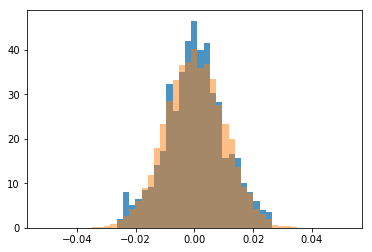

NormaltestResult(statistic=0.33615582004891253, pvalue=0.84528797571229464)
Ks_2sampResult(statistic=0.030094117647058827, pvalue=0.41560386379456693)


In [137]:
compare = np.random.normal(np.mean(dS_S_cutoff), np.std(dS_S_cutoff), 10000)   #comparison-sample; normally distributed
plt.hist(dS_S_cutoff, bins=np.linspace(-4*np.std(dS_S), 4*np.std(dS_S), 50), alpha = 0.8, normed = True);
plt.hist(compare, bins=np.linspace(-4*np.std(dS_S), 4*np.std(dS_S), 50), alpha = 0.5, normed = True)
plt.show()
print(ms.normaltest(dS_S_cutoff))
print(st.ks_2samp(dS_S_cutoff, compare))

The fit is still not very good, but it is clearly closer to a normal distribution than before. This indicates that the tails might be too fat for a normal distribution.

The Market Portfolio
=====

Since I don't know the market capitalization of the individual stocks, it's not directly possible to construct the S&P-500 index from this data. But I'll use the data of those stocks where the data is complete, and then approximate the market portfolio by PCA.